In [38]:
import os
import pandas as pd
import numpy as np  
import itertools
import numpy.typing as npt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import datetime
from keras import regularizers

os.getcwd()
os.chdir("C:\\Users\\nathi\\Downloads\\3 Semester\\AMS\\")

In [39]:
def ts_train_test_split(
    ts: npt.ArrayLike, training_size: int
) -> tuple[pd.DataFrame, pd.DataFrame] | tuple[np.ndarray, np.ndarray]:
    """
    Time series train test split. Performs a single split of the series.

    Parameters:
    ----------
    ts: array-like
        univariate time series data set

    training_size: int
        Size of the training set. The test set length

    Returns:
    -------
    Tuple[pd.DataFrame, pd.DataFrame] | Tuple[np.ndarray, np.ndarray]
        A tuple containing the training and test sets,
        either as DataFrames or NumPy arrays
    """
    if training_size >= len(ts):
        raise ValueError("training_size must be < length of series")

    if isinstance(ts, pd.DataFrame):
        return ts.iloc[:training_size], ts.iloc[training_size:]

    return np.asarray(ts[:training_size]), np.asarray(ts[training_size:])


# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer= regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [40]:
# pip install tensorflow

In [41]:
path = 'datasets_pseudo/Threshold/'
names = os.listdir(path)
date_str = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")
dfs = {}

for name in names:
    machine, material, component, _ = name.replace('.csv', '').split('_')
    tempdf = pd.read_csv(f"{path}\\{name}", index_col=0) 
    # tempdf[['Machine', 'Material', 'Component']] = [machine, material, component]
    print(f"Size of {name}: {tempdf.shape}")

    dfs[name.replace('.csv', '')] = tempdf

df = pd.concat(dfs.values(), ignore_index=True)


Size of threshold_CMX1_AL_CP1.csv: (433666, 63)
Size of threshold_CMX1_AL_CP2.csv: (74822, 63)
Size of threshold_CMX1_S_CP1.csv: (244772, 63)
Size of threshold_CMX1_S_CP2.csv: (45468, 63)
Size of threshold_DMC2_AL_CP1.csv: (510050, 63)
Size of threshold_DMC2_AL_CP2.csv: (64337, 63)
Size of threshold_DMC2_S_CP1.csv: (263913, 63)
Size of threshold_DMC2_S_CP2.csv: (42016, 63)


In [42]:
columns_to_predict = ['CURRENT|1', 'CURRENT|2', 'CURRENT|3', 'CURRENT|6']

latent_dims = [4, 8, 10]
contamination_values = [0.005, 0.001, 0.01]
epochs_list = [25, 50, 75, 100 ]
batch_sizes = [32, 64, 128]

feature_sets = {
    'all_sensors': list(set(df.columns) - set(['Machine', 'Material', 'Component']) - set(['CURRENT|1_Peak', 'CURRENT|2_Peak', 'CURRENT|3_Peak', 'CURRENT|6_Peak'])), 
}

numeric_features = feature_sets['all_sensors']

In [43]:
# autoencoder model --> encodes input variables into a lower dimension, and then decodes back into the higher dimension. Anomalies (peaks) are identified based on high
#  reconstruction error between the encoder and decoder. 

Training for column CURRENT|1
training for contamination value = 0.005, number of epochs = 25, batch size = 32
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step
Precision: 0.587
Recall:    0.188
F1 Score:  0.285


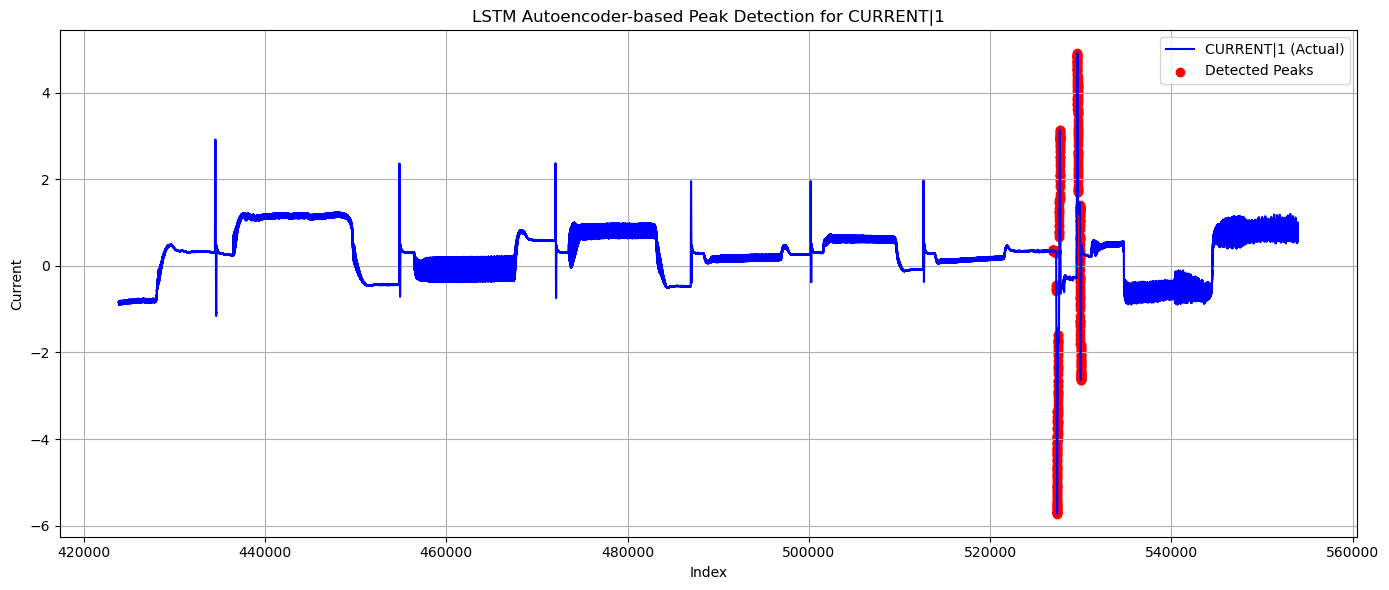

training for contamination value = 0.005, number of epochs = 25, batch size = 64
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step
Precision: 0.797
Recall:    0.255
F1 Score:  0.387


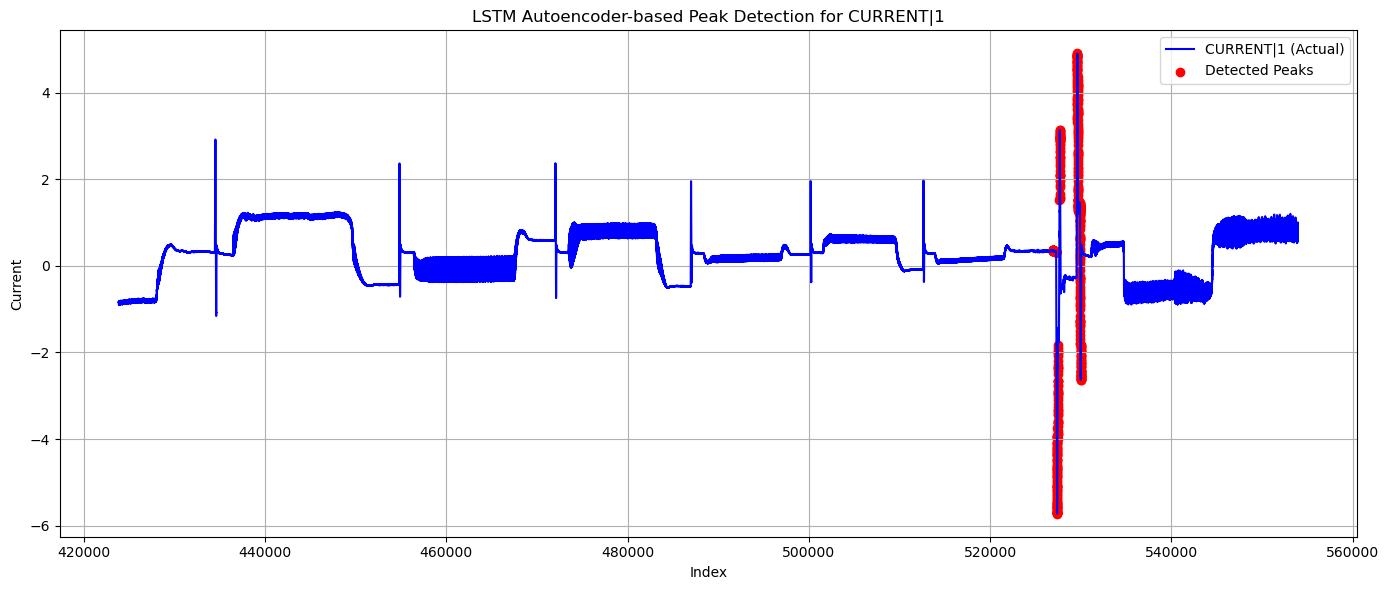

training for contamination value = 0.005, number of epochs = 25, batch size = 128
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Precision: 0.846
Recall:    0.271
F1 Score:  0.410


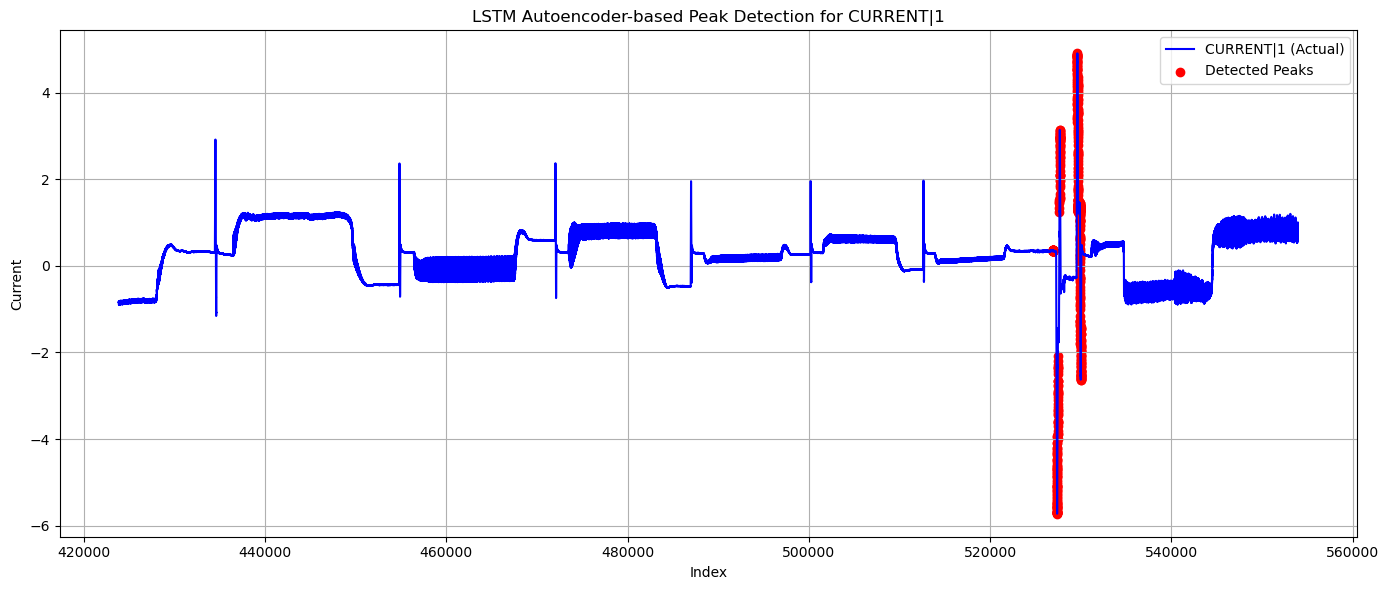

training for contamination value = 0.005, number of epochs = 50, batch size = 32
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Precision: 0.802
Recall:    0.257
F1 Score:  0.389


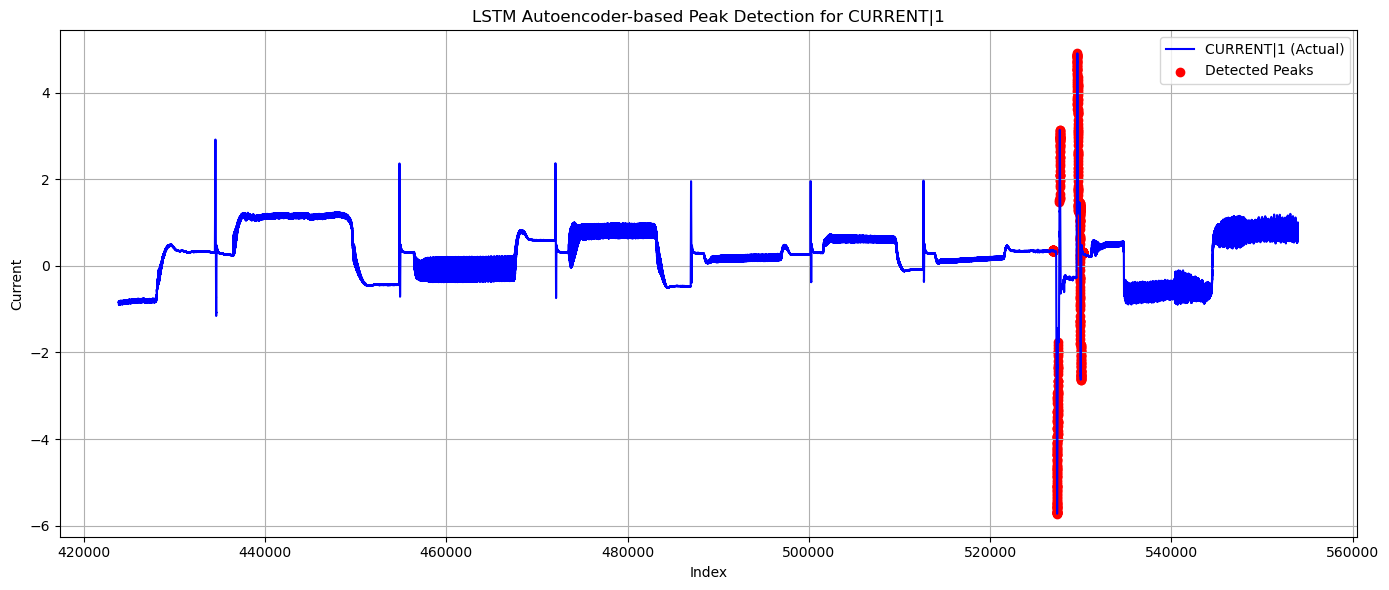

training for contamination value = 0.005, number of epochs = 50, batch size = 64
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step
Precision: 0.717
Recall:    0.230
F1 Score:  0.348


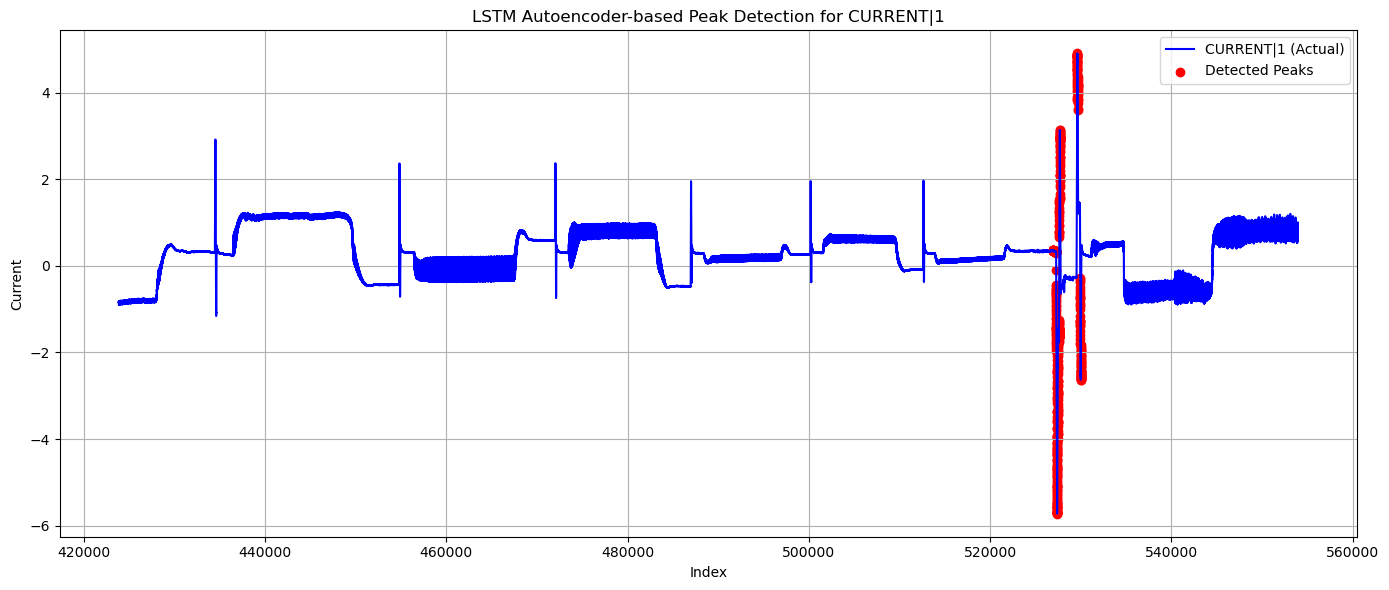

training for contamination value = 0.005, number of epochs = 50, batch size = 128
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Precision: 0.654
Recall:    0.209
F1 Score:  0.317


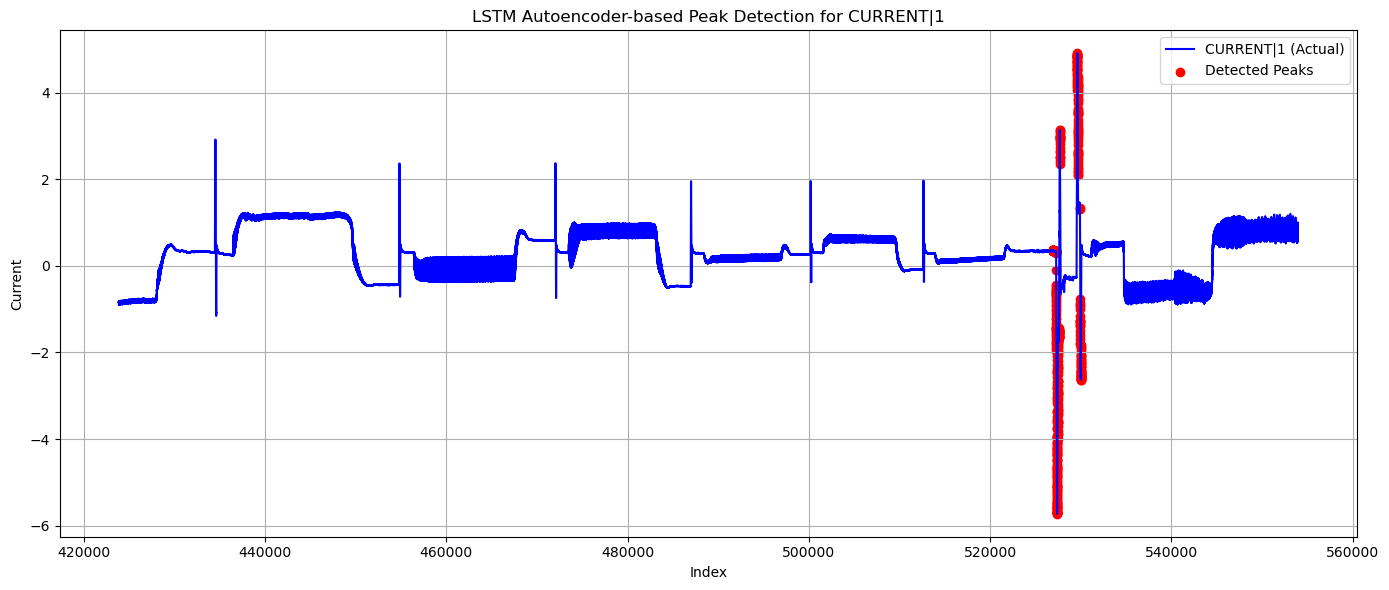

training for contamination value = 0.005, number of epochs = 75, batch size = 32
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_9 (RepeatVector)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step
Precision: 0.846
Recall:    0.271
F1 Score:  0.410


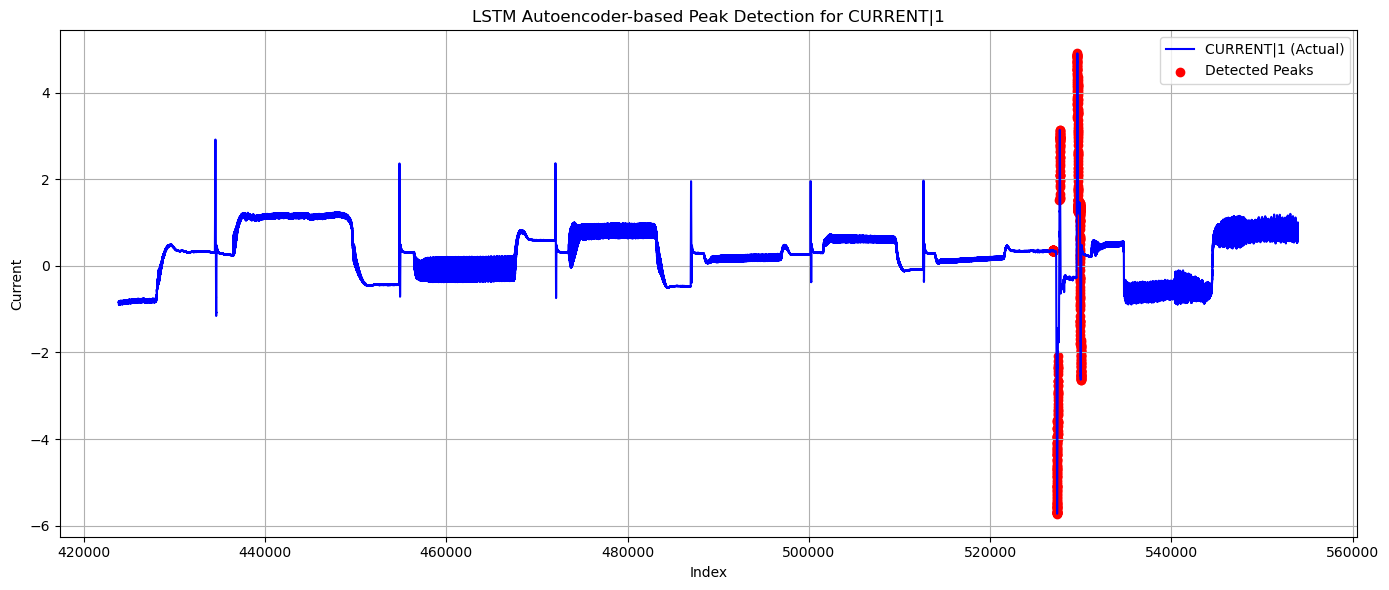

training for contamination value = 0.005, number of epochs = 75, batch size = 64
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_10 (RepeatVector) │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step
Precision: 0.816
Recall:    0.261
F1 Score:  0.396


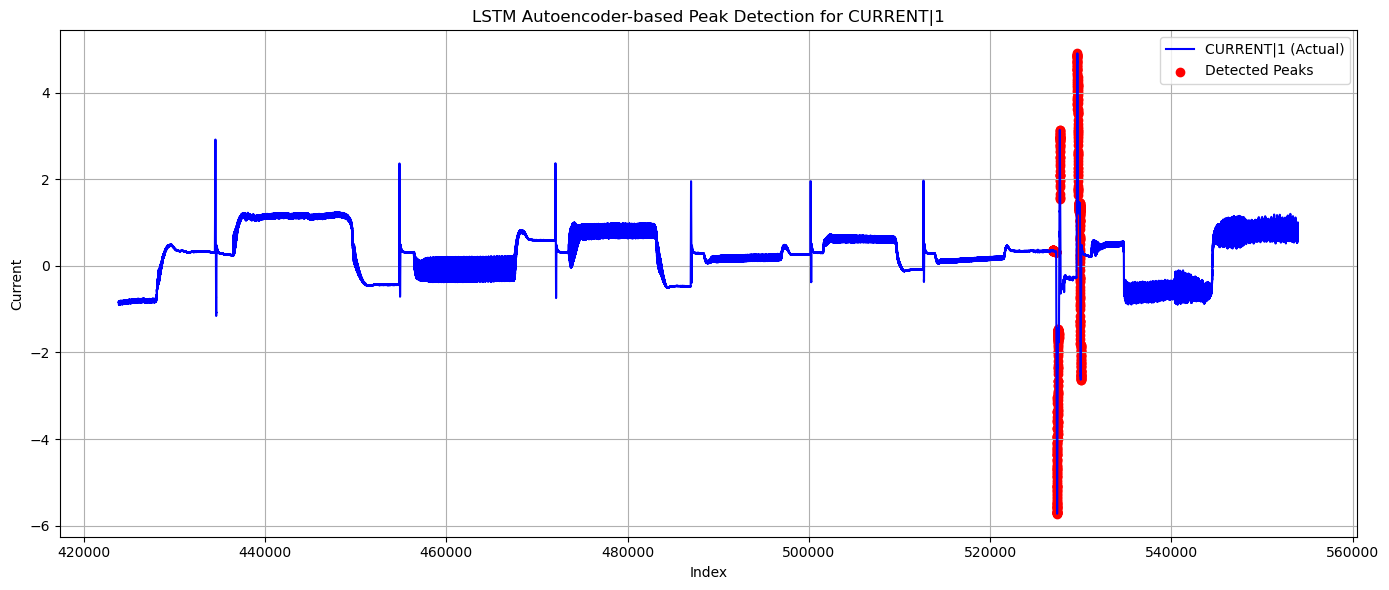

training for contamination value = 0.005, number of epochs = 75, batch size = 128
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_11 (RepeatVector) │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step
Precision: 0.805
Recall:    0.258
F1 Score:  0.390


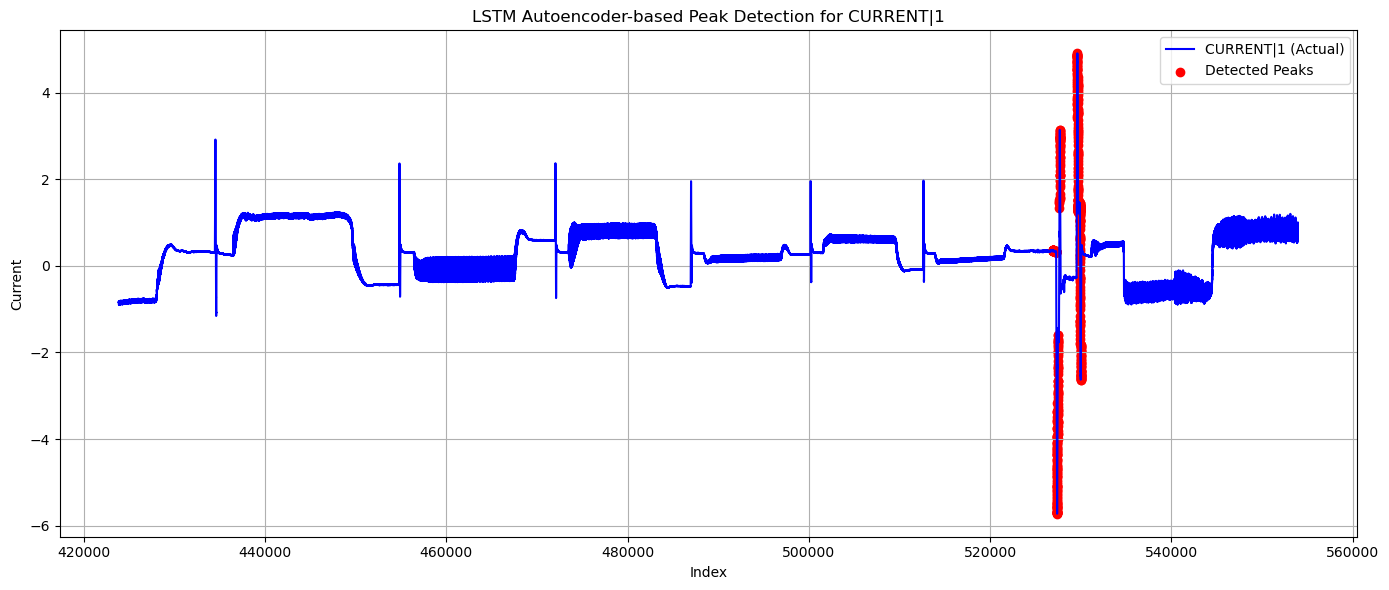

training for contamination value = 0.005, number of epochs = 100, batch size = 32
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_12 (RepeatVector) │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

4066/4066 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
Precision: 0.616
Recall:    0.197
F1 Score:  0.299


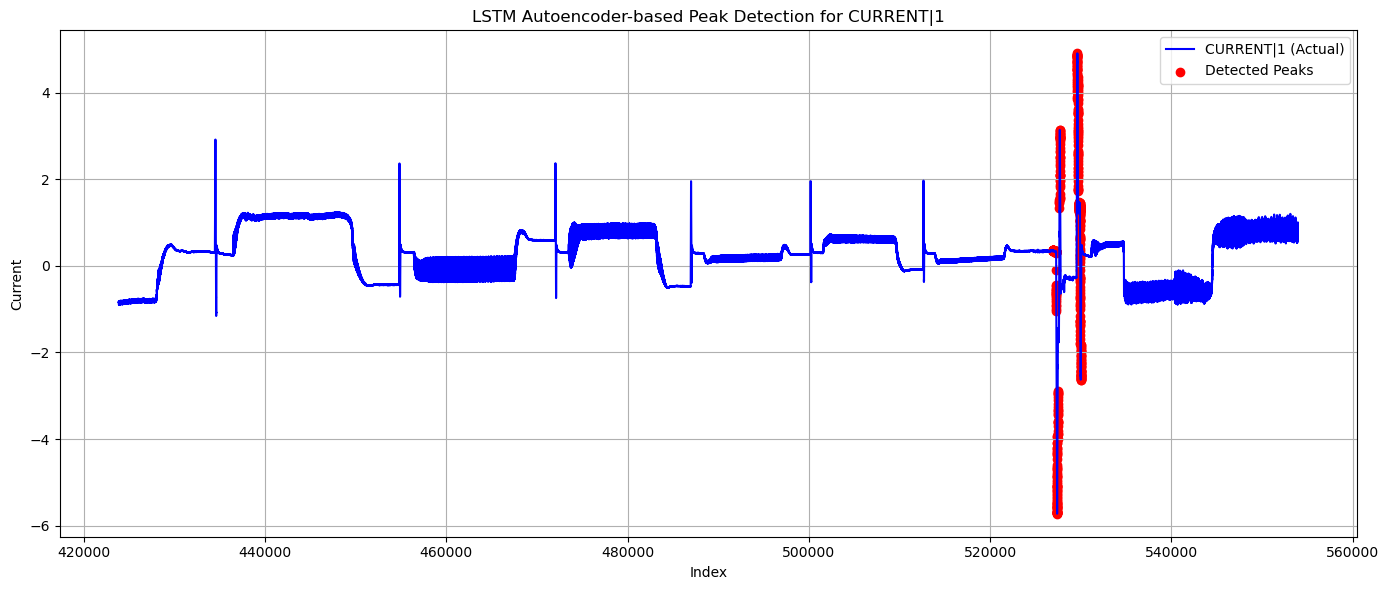

training for contamination value = 0.005, number of epochs = 100, batch size = 64
Training data shape: (303566, 1, 56)
Test data shape: (130100, 1, 56)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 1, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 1, 16)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_13 (RepeatVector) │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 1, 56)          │           952 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,448 (29.09 KB)

 Trainable params: 7,448 (29.09 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
results = []


for name, target_column in list(itertools.product(names, columns_to_predict)):
    print(f'Training for column {target_column}')
    pseudo_label_col = f"{target_column}_Peak"

    data = pd.read_csv(f"{path}\\{name}", index_col=0) 

    # divide to test and train
    train_size = round(data.shape[0]*0.7)
    target_train, target_test = ts_train_test_split(data[[target_column]], train_size)
    X_train, X_test = ts_train_test_split(data[numeric_features], train_size)
    y_train, y_test = ts_train_test_split(data[[pseudo_label_col]], train_size)
    idx_train, idx_test = ts_train_test_split(data.index, train_size)

    # preprocess numerical variables
    scaler_X = MinMaxScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    # Scale target variable
    scaler_y = MinMaxScaler()
    y_train = scaler_y.fit_transform(y_train)
    y_test = scaler_y.transform(y_test)

    y_train_pseudo = y_train.astype(bool)  # binary labels
    y_test_pseudo = y_test.astype(bool)  # binary labels


    # --- Configuration ---
    for contamination, epochs, batch_size in list(itertools.product(contamination_values, epochs_list, batch_sizes)):
        
        print(f'training for contamination value = {contamination}, number of epochs = {epochs}, batch size = {batch_size}')

        # --- Autoencoder Model ---
        # input_dim = X_train.shape[1]
        # autoencoder = Sequential([
        #     Dense(512, activation='elu', input_shape=(input_dim,)),
        #     Dense(128, activation='elu'),
        #     Dense(latent_dim, activation='linear', name='bottleneck'),
        #     Dense(128, activation='elu'),
        #     Dense(512, activation='elu'),
        #     Dense(input_dim, activation='sigmoid')
        # ])
        # autoencoder.compile(optimizer=Adam(), loss='mse')

        # reshape inputs for LSTM [samples, timesteps, features]
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        print("Training data shape:", X_train.shape)
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        print("Test data shape:", X_test.shape)

        autoencoder = autoencoder_model(X_train)
        autoencoder.compile(optimizer='adam', loss='mae')
        autoencoder.summary()

        # Train
        autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test), verbose=0)

        # Reconstruction and anomaly detection on test set
        X_recon = autoencoder.predict(X_test)
        X_pred = X_recon.reshape(X_recon.shape[0], X_recon.shape[2])
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])

        pred_errors = np.mean(np.abs(X_test - X_pred), axis=1)

        # Set threshold by contamination (e.g., top 1% highest errors)
        threshold = np.quantile(pred_errors, 1 - contamination)
        peaks_detected = pred_errors > threshold

        # --- Evaluate against pseudo labels ---
        precision = precision_score(y_test_pseudo, peaks_detected, zero_division=0)
        recall = recall_score(y_test_pseudo, peaks_detected, zero_division=0)
        f1 = f1_score(y_test_pseudo, peaks_detected, zero_division=0)
        n_detected = np.sum(peaks_detected)

        results.append({
            'Dataset': name, 
            'Column': target_column,
            'Contamination': contamination,
            'Epochs': epochs, 
            'Batch size': batch_size,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Detected_Peaks': n_detected
        })

        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1 Score:  {f1:.3f}")

        # --- Plotting ---
        # y_test_rescaled = scaler_y.inverse_transform(y_test)
        
        plt.figure(figsize=(14, 6))
        plt.plot(idx_test, target_test, label=f'{target_column} (Actual)', color='blue')
        plt.scatter(
            idx_test[peaks_detected],
            target_test.iloc[peaks_detected],
            color='red', label='Detected Peaks', marker='o'
        )
        plt.title(f"LSTM Autoencoder-based Peak Detection for {target_column}")
        plt.xlabel("Index")
        plt.ylabel("Current")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='F1', ascending=False, inplace=True)

results_df.to_csv(f"Results/LSTM_results_{date_str}_all.csv")

